# CM3015 Machine Learning & Neural Networks Midterm  |  Jolene Goh

The wine dataset provided by Scikit-learn has been utilised for this analysis. The following section involves loading the dataset, splitting them into training and testing sets before standardising the features. This process is performed to eliminate the influence of different scales and prevent any potential biases that may occur.

## 1.0 Exploratory Data Analysis

### 1.1 Summary Statistics

By analysing the generated statistics, we can determine if the features needs to be scaled or not. The scaling technique normalises the distribution and magnitude of features hence reducing the inconsistencies may arise during data training. From the summary below, we can determine feature scaling is required. The aim is to transform the data into a standardised range in order to prevent larger values from having a disproportionate impact on the results, effectively robustifying the model.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import necessary modules
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.base import BaseEstimator, ClassifierMixin
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load dataset
wine = load_wine()
wine_df = pd.DataFrame(data=wine.data, columns=wine.feature_names)
wine_df['target'] = wine.target

# Print summary
print(wine_df.describe())

# Determine if scaling is required
feature_range = wine_df.max() - wine_df.min()
if (feature_range > 1).any():
    print("\nScaling Required")
else:
    print("\nScaling Not Required")

          alcohol  malic_acid         ash  alcalinity_of_ash   magnesium  \
count  178.000000  178.000000  178.000000         178.000000  178.000000   
mean    13.000618    2.336348    2.366517          19.494944   99.741573   
std      0.811827    1.117146    0.274344           3.339564   14.282484   
min     11.030000    0.740000    1.360000          10.600000   70.000000   
25%     12.362500    1.602500    2.210000          17.200000   88.000000   
50%     13.050000    1.865000    2.360000          19.500000   98.000000   
75%     13.677500    3.082500    2.557500          21.500000  107.000000   
max     14.830000    5.800000    3.230000          30.000000  162.000000   

       total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
count     178.000000  178.000000            178.000000       178.000000   
mean        2.295112    2.029270              0.361854         1.590899   
std         0.625851    0.998859              0.124453         0.572359   
min         0.9

### 1.2 Sample Size

For a dataset to be considered balanced, each class should ideally represent an equal proportion of the total samples. Given that the wine dataset contains three classes, each class should comprise approximately 33% of the data. The equal distribution gives equal priority to all classes and prevents the model from favoring any one class over the others. Here, we determine the dataset is imbalanced and F1 Score evaluation to be utilised in assessing the model performance moving forward.

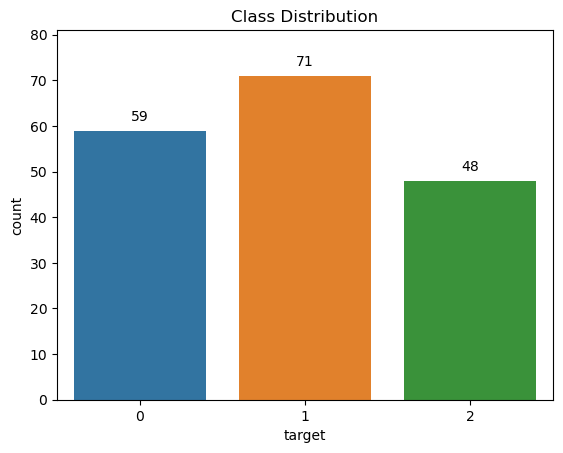

Imbalanced Dataset
Evaluation Metric: F1 Score
178 Data Points
Validation Technique: K-Fold Cross-Validation


In [3]:
# Visualise class distribution
ax = sns.countplot(x='target', data=wine_df)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
               (p.get_x() + p.get_width()/2, p.get_height()),
               ha='center', va='center',
               xytext=(0, 10),
               textcoords='offset points')

plt.ylim(0, max(wine_df['target'].value_counts()+10))
plt.title('Class Distribution')
plt.show()

# Determine if dataset is balanced or imbalanced
class_count = wine_df['target'].value_counts()

if class_count.nunique() == 1:
    print("Balanced Dataset")
    evaluation_metric = "Accuracy"
else:
    print("Imbalanced Dataset")
    evaluation_metric = "F1 Score"

print("Evaluation Metric:", evaluation_metric)

# Determine validation technique based on size of data
data_count = len(wine_df)
print(data_count, "Data Points")

if (data_count < 1000):
    print("Validation Technique: K-Fold Cross-Validation")
else:
    print("Validation Technique: Cross-Validation on Validation Dataset")

### 1.3 Pair Plots

The pair plots are used to visualise the relationship between each pair of variables within the dataset. The combination of scatter plots and histograms gives comprehensive overview of the feature selection most likely to contribute to the prediction task. This serves as a tool and allows us to obtain information regarding the data structure and any underlying correlations.

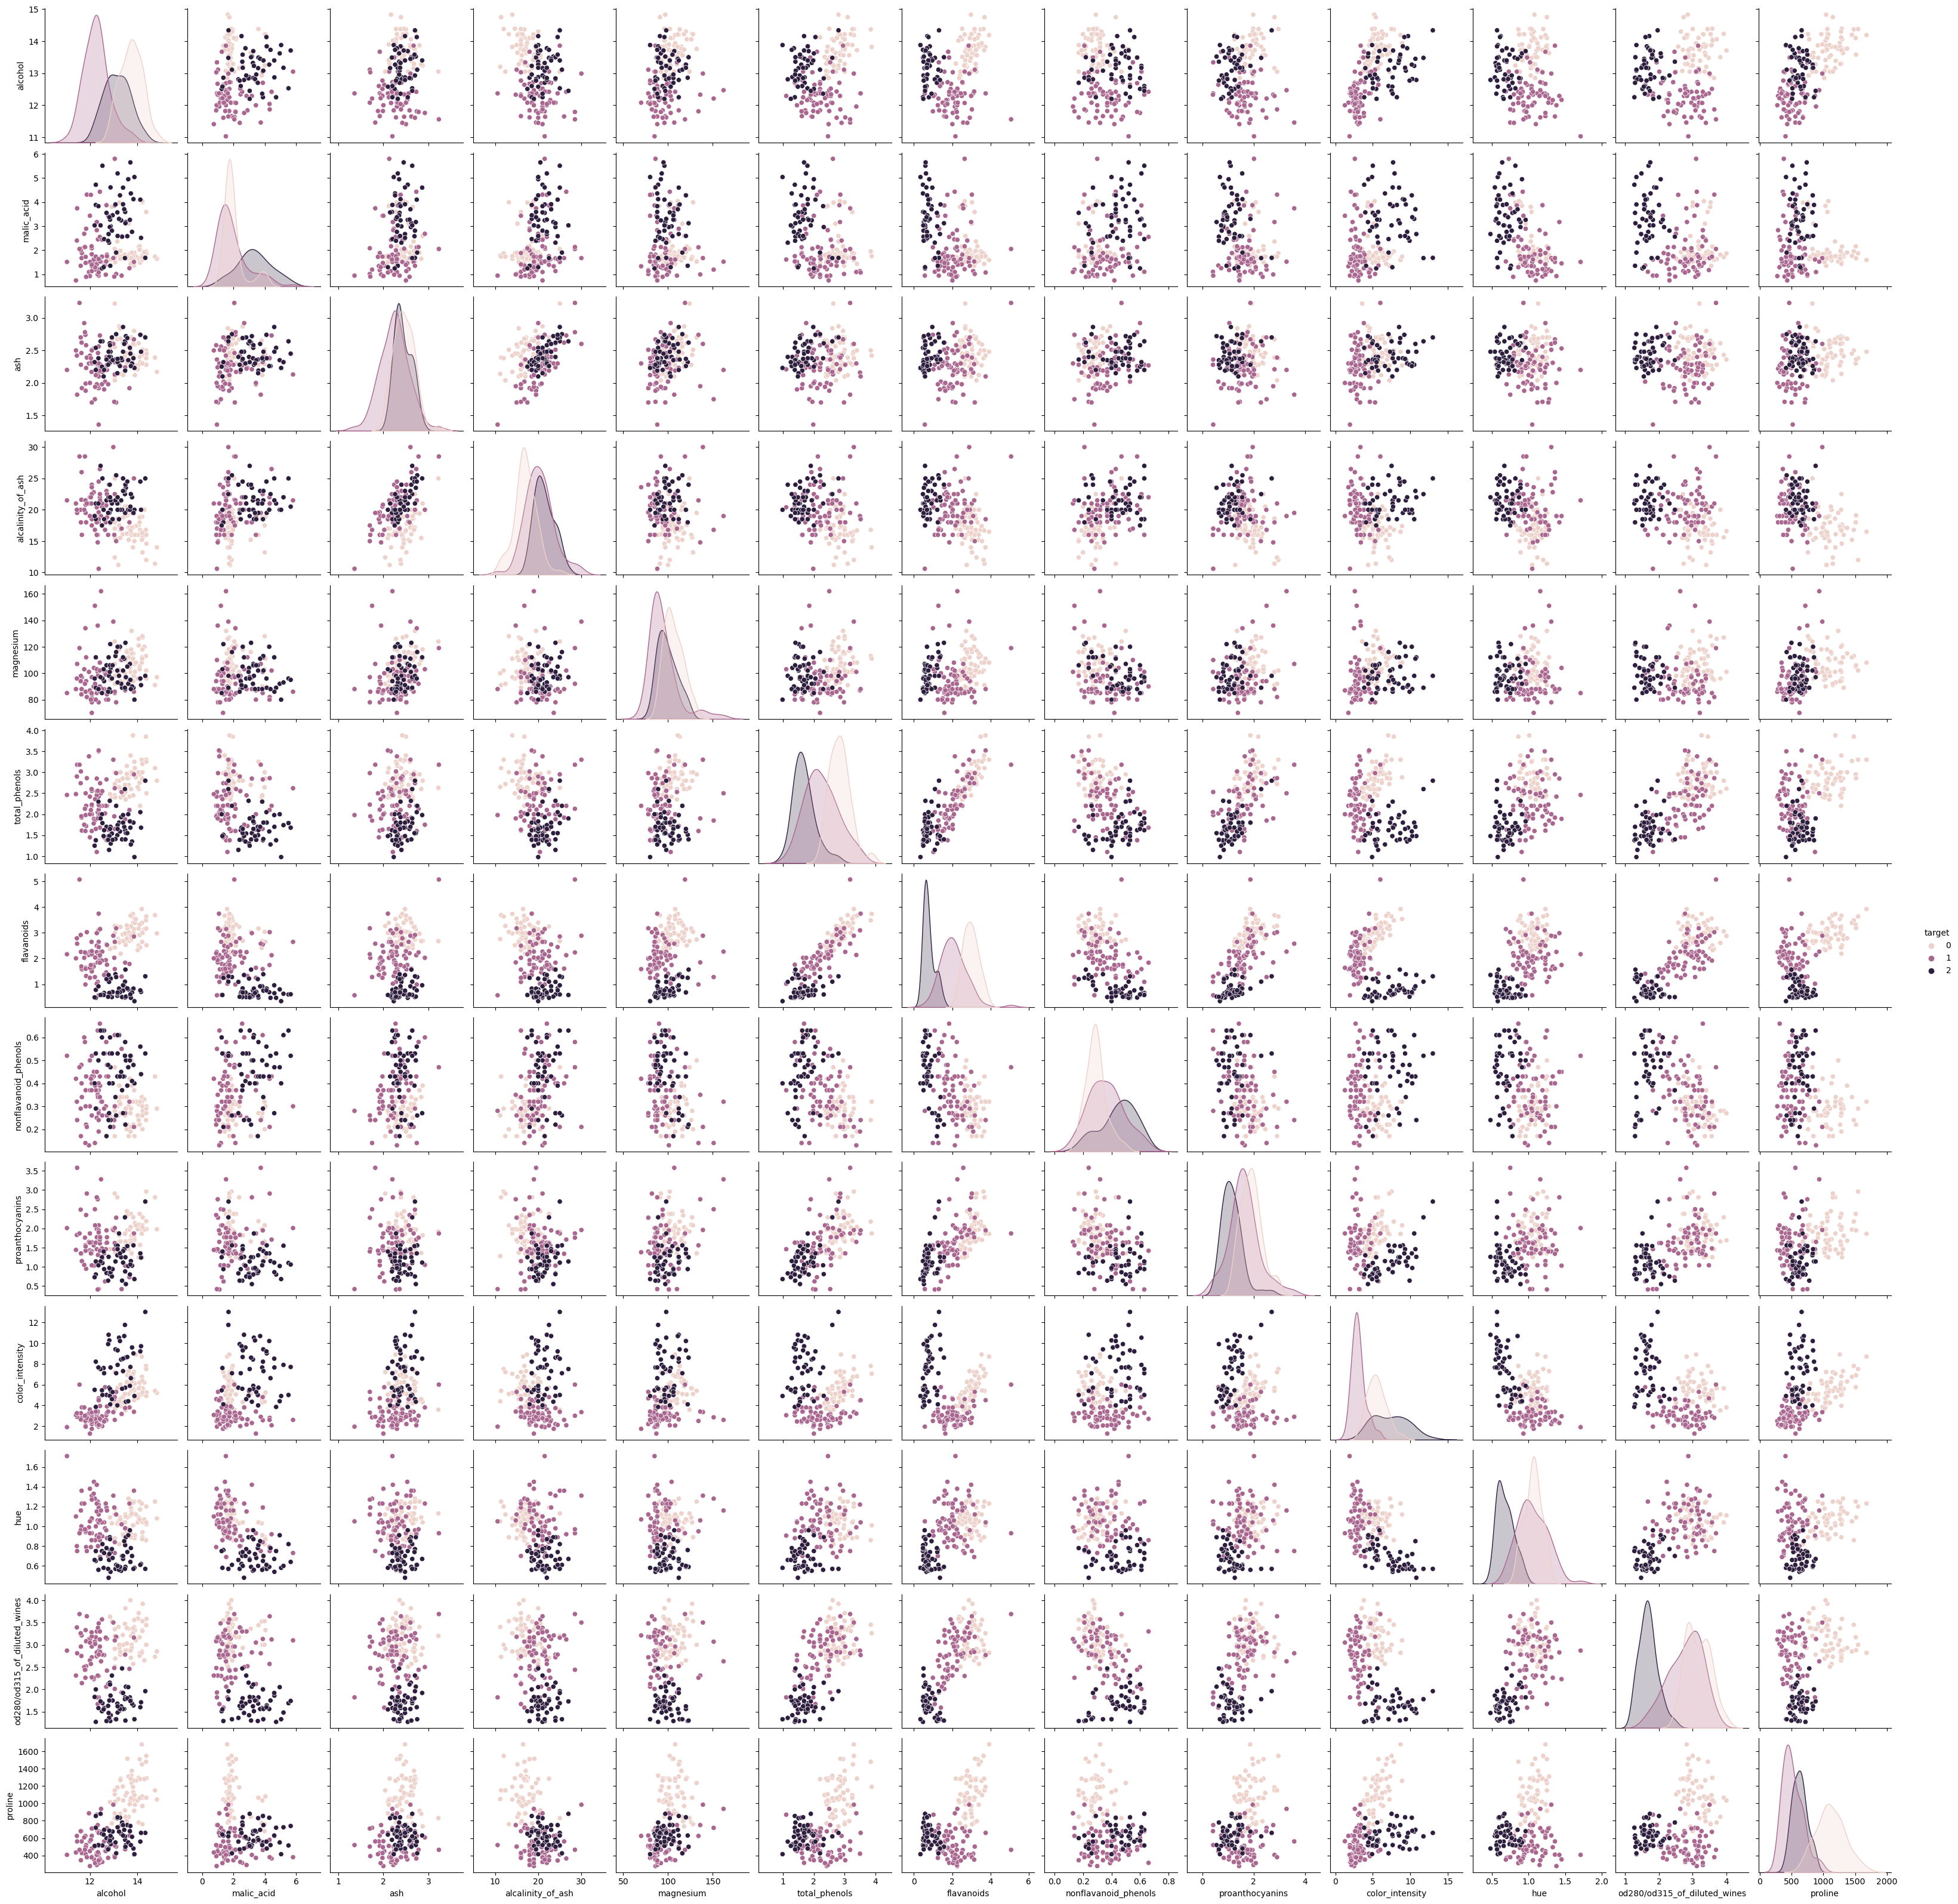

In [4]:
# Visualise feature symmetricity
sns.pairplot(wine_df, hue='target')
plt.show()

### 1.4 Box Plot

The box plot displays data distribution across quartiles, aiding in the identification of outliers. Due to the compression of data points, attempting to visually distinguish the outliers can be a real challenge. During the preprocessing stage, the 1.5 * IQR rule will be applied to systematically rule out the outliers to prevent our ML models from leveraging towards anomalous data points.

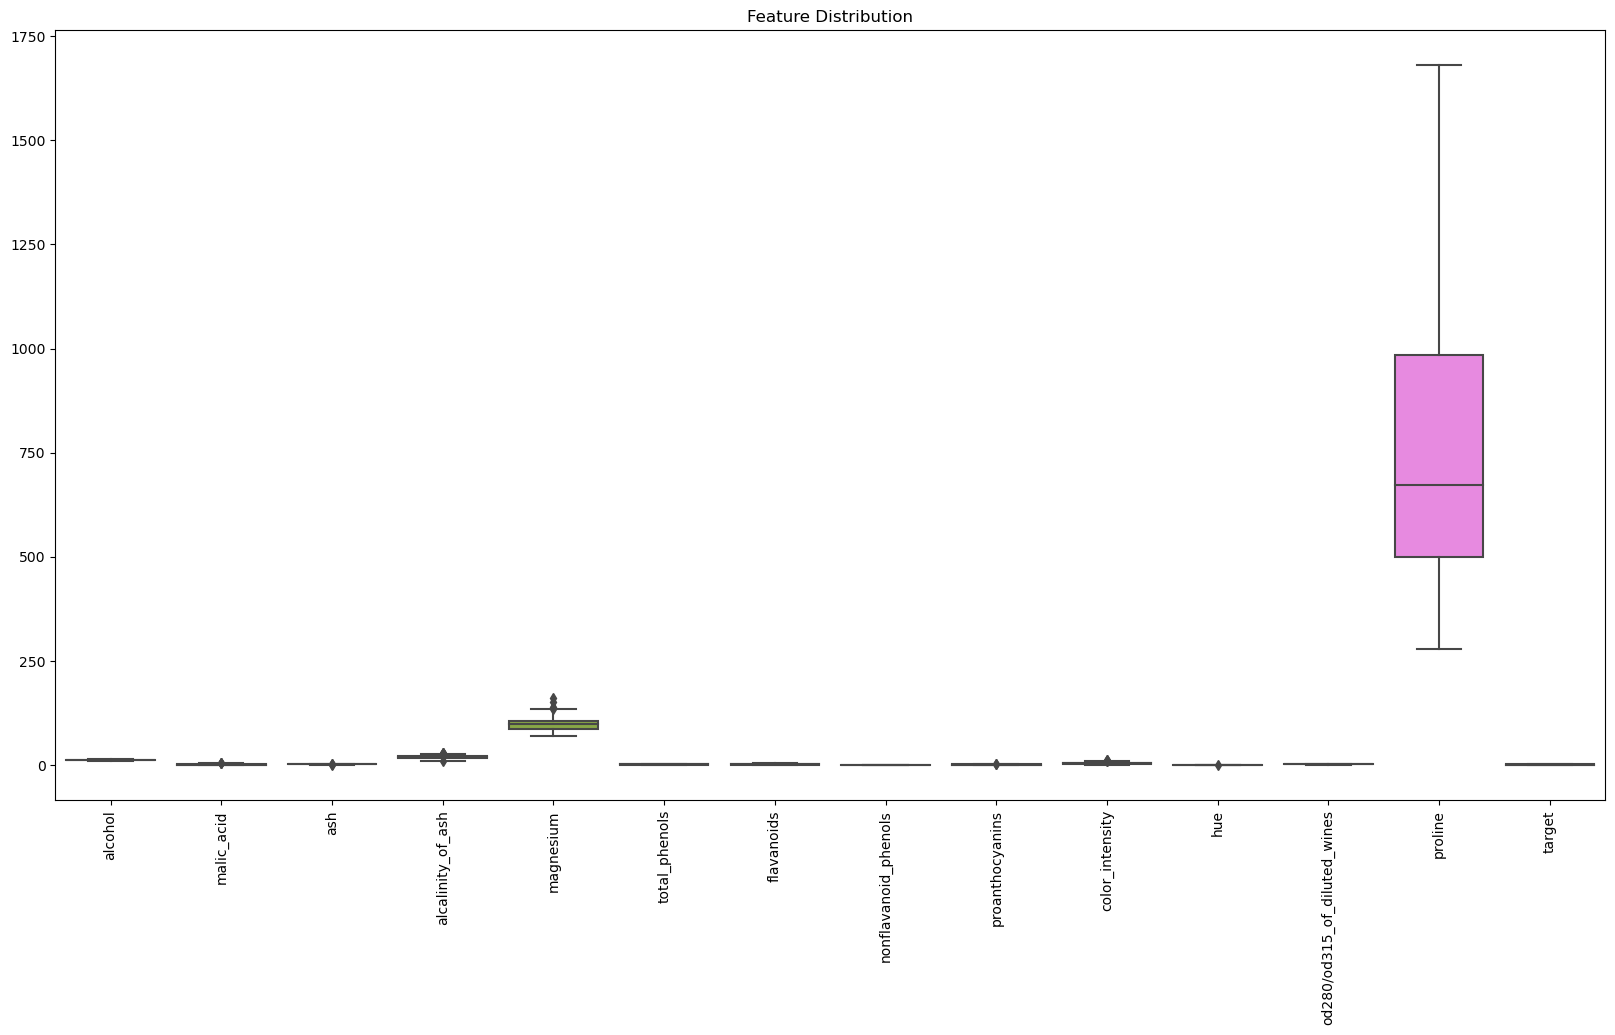

In [5]:
# Out-of-distribution detection
plt.figure(figsize=(20, 10))
sns.boxplot(data=wine_df)
plt.title('Feature Distribution')
plt.xticks(rotation=90)
plt.show()

## 2.0 Establishing Baseline (Naive Model)

The baseline accuracy serves as a reference point for evaluating the performance of our ML models. It can be determined by calculating the (number of instances of majority class) / (total number of instances). This formula represents the accuracy achieved by a naive model that predicts the majority class for all instances. This is a benchmark for assessing the model's effectiveness by leveraging information from input data in comparison to random guessing.

In [6]:
# Calculate baseline accuracy
majority_class_count = class_count.max()
baseline_accuracy = majority_class_count / data_count

print(f"Baseline Accuracy: {baseline_accuracy:.2f}")

Baseline Accuracy: 0.40


## 3.0 Data Pre-Processing

### 3.1 Outlier Removal

In order to enhance the robustness of our ML models, data points that deviate significantly from the majority must be addressed. These outliers can have a disproportionate influence on model training which may lead to skewed or biased results towards certain extreme values. Notably, algorithms such as Logistic Regression and Naive Bayes are particularly sensitive towards irregularities, making removal a crucial step in the preprocessing pipeline.

In [7]:
# Calculate IQR using Q1 & Q3
Q1 = wine_df.quantile(0.25)
Q3 = wine_df.quantile(0.75)
IQR = Q3 - Q1

# Determine lower & upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers using 1.5xIQR Rule
outliers = ((wine_df < lower_bound) | (wine_df > upper_bound)).any(axis=1)
outliers_count = outliers.sum()

# Filter out outliers
filtered_df = wine_df[~outliers]

print(f"Unfiltered dataset: {wine_df.shape}")
print(f"Filtered dataset: {filtered_df.shape}")
print(f"Number of outliers removed: {outliers_count}")

Unfiltered dataset: (178, 14)
Filtered dataset: (161, 14)
Number of outliers removed: 17


### 3.2 Train-Test Split

This step partitions the dataset into two disjoint subsets: a training set and a testing set. The split is performed with a ratio of 8:2 where 80% of the data is used for training while the remaining 20% is used for testing. This practice ensures sufficient data for model training while having a separate model for performance evaluation which includes overfitting/ underfitting detection.

In [8]:
# Arrange data into features & target
X = filtered_df.drop('target', axis=1)
y = filtered_df['target']

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# Print dimensionality
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (128, 13)
X_test: (33, 13)
y_train: (128,)
y_test: (33,)


### 3.3 Feature Scaling

The standard scaler technique is used to standardise the range of features in the dataset, ensuring they share a similar scale. This improves the overall model performance, leading to more accurate and reliable predictions.

In [9]:
# Initialise standard scaler
scaler = StandardScaler()
scaler.fit(X_train)

Xs_train = scaler.transform(X_train)
Xs_test = scaler.transform(X_test)

y_train = y_train.values
y_test = y_test.values

# Convert scaled features
scaled_features = pd.DataFrame(X_train, columns=X.columns)

# Print scaled summary
print(scaled_features.describe())

          alcohol  malic_acid         ash  alcalinity_of_ash   magnesium  \
count  128.000000  128.000000  128.000000         128.000000  128.000000   
mean    12.998672    2.272344    2.359297          19.088281   98.742188   
std      0.804587    1.019831    0.244638           2.964637   11.856920   
min     11.410000    0.740000    1.700000          11.400000   78.000000   
25%     12.370000    1.607500    2.225000          17.000000   88.000000   
50%     13.040000    1.845000    2.360000          19.000000   98.000000   
75%     13.672500    3.000000    2.522500          21.000000  106.250000   
max     14.830000    5.190000    2.920000          27.000000  134.000000   

       total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
count     128.000000  128.000000            128.000000       128.000000   
mean        2.289219    2.077266              0.360625         1.570469   
std         0.654131    0.992608              0.123962         0.546155   
min         0.9

In [10]:
# Re-print dimensionality
print(f"Xs_train: {Xs_train.shape}")
print(f"Xs_test: {Xs_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

Xs_train: (128, 13)
Xs_test: (33, 13)
y_train: (128,)
y_test: (33,)


## 4.0 Cross-Validation

Cross-validation is used to provide an accurate estimate of a model's performance and detect issues such as overfitting and underfitting. This step is particularly useful for smaller, more limited data such as the Scikit-learn wine dataset.

### 4.1 Custom K-Nearest Neighbors Classifier (Implemented from Scratch)

This custom K-Nearest Neighbors classifier tunes the hyperparameter 'n-neighbors' which represents the number of neighbors to consider during prediction-making. By performing cross-validation, the most optimal value of 'n-neighbors' can be identified. The custom K-Nearest Neighbors model made from scratch is implemented below:

In [11]:
# My Custom KNeighborsClassifier
class MyKNeighborsClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=3, metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.metric = metric

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self

    def predict(self, X):
        y_pred = []
        for x in X:
            if self.metric == 'euclidean':
                distances = [np.sqrt(np.sum((x - x_train) ** 2)) for x_train in self.X_train]
            elif self.metric == 'manhattan':
                distances = [np.sum(np.abs(x - x_train)) for x_train in self.X_train]
            n_indices = np.argsort(distances)[:self.n_neighbors]
            n_nearest_labels = [self.y_train[i] for i in n_indices]
            most_common_labels = Counter(n_nearest_labels).most_common(1)
            y_pred.append(most_common_labels[0][0])
        return np.array(y_pred)

# Define parameter grid for My Custom KNeighborsClassifier
knn_parameter_grid = {
    'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                   11, 12, 13, 14, 15, 16, 17, 18,
                   19, 20],
    'metric': ['euclidean', 'manhattan']
}

# Attain the best model for My Custom KNeighborsClassifier
my_knn_grid_search = GridSearchCV(MyKNeighborsClassifier(), knn_parameter_grid, cv=5, scoring='f1_weighted', refit=True)
my_knn_grid_search.fit(Xs_train, y_train)

# Print the best hyperparameters for My Custom KNeighborsClassifier
best_knn = my_knn_grid_search.best_estimator_
print("Best parameters for MyKNeighborsClassifier:", my_knn_grid_search.best_params_)
print("Best scores for MyKNeighborsClassifier:", my_knn_grid_search.best_score_)

Best parameters for MyKNeighborsClassifier: {'metric': 'euclidean', 'n_neighbors': 1}
Best scores for MyKNeighborsClassifier: nan


### 4.2 Comparative Analysis of Custom vs. Scikit-Learn K-Nearest Neighbors Implementations

In this section, we test for the correctness of our K-Nearest Neighbors algorithm implemented from scratch in comparison to the K-Nearest Neighbors algorithm implemented from the Scikit-learn library. This comparative analysis determines if our implementation is on par with or differs greatly from the pre-built.

In [12]:
# Predict using Custom KNeighborsClassifier
my_pred = MyKNeighborsClassifier(n_neighbors=3, metric='euclidean').fit(Xs_train, y_train).predict(Xs_train)

# Predict using Scikit-learn's KNeighborsClassifier
skl_pred = KNeighborsClassifier(n_neighbors=3, metric='euclidean').fit(Xs_train, y_train).predict(Xs_train)

# Print prediction result
print("Comparison of Custom vs. Scikit-Learn KNN Predictions:")
print(f"Are the predictions identical?", np.all(my_pred == skl_pred))

Comparison of Custom vs. Scikit-Learn KNN Predictions:
Are the predictions identical? True


### 4.3 Decision Tree Classifier

Sci-kit learn's implementation of the Decision Tree model is used below:

In [13]:
# Define parameter grid for DecisionTreeClassifier
dtree_parameter_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 
                  10, 11, 12, 13, 14, 15, 16],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 
                          10, 11, 12, 13, 14, 15, 16],
    'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 
                         10, 11, 12, 13, 14, 15, 16]
}

# Attain the best model for DecisionTreeClassifier
dtree_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), dtree_parameter_grid, cv=5, scoring='f1_weighted')
dtree_grid_search.fit(Xs_train, y_train)

# Print the best hyperparameters for DecisionTreeClassifier
best_dtree = dtree_grid_search.best_estimator_
print("Best parameters for DecisionTreeClassifier:", dtree_grid_search.best_params_)
print("Best scores for DecisionTreeClassifier:", dtree_grid_search.best_score_)

Best parameters for DecisionTreeClassifier: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2}
Best scores for DecisionTreeClassifier: 0.8827049297451774


### 4.4 Logistic Regression Classifier

Sci-kit learn's implementation of the Logistic Regression model is used below:

In [14]:
# Define parameter grid for LogisticRegressionClassifier
logregression_parameter_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l2', 'l1'],
    'solver': ['lbfgs', 'sag']
}

# Attain the best model for LogisticRegressionClassifier
logregression_grid_search = GridSearchCV(LogisticRegression(random_state=42), logregression_parameter_grid, cv=5, scoring='f1_weighted')
logregression_grid_search.fit(Xs_train, y_train)

# Print the best hyperparameters for LogisticRegressionClassifier
best_logregression = logregression_grid_search.best_estimator_
print("Best parameters for LogisticRegressionClassifier:", logregression_grid_search.best_params_)
print("Best scores for LogisticRegressionClassifier:", logregression_grid_search.best_score_)

Best parameters for LogisticRegressionClassifier: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best scores for LogisticRegressionClassifier: 0.984373938082378


### 4.5 K-Nearest Neighbors Complexity (Overfitting Investigation)

An overfitting has occurred. This can happen when a model performs well on training data but poorly on unseen test data. By evaluating models of varying complexities, the optimal complexity can be identified. The validation curve (K-Nearest Neighbors) is displayed below:

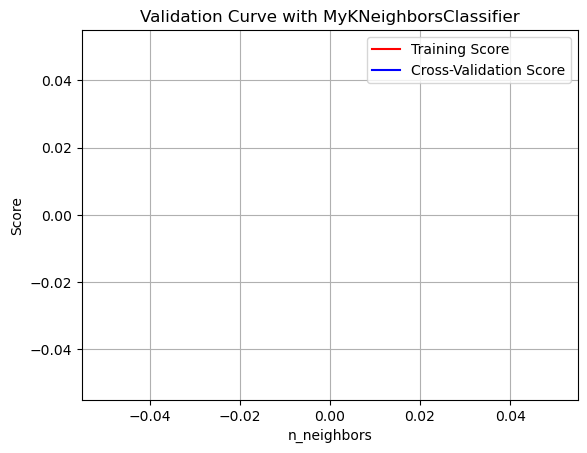

In [15]:
# Define range for MyKNeighborsClassifier
param_range = np.arange(1, 25)

# Compute using validation_curve
train_scores, test_scores = validation_curve(
    MyKNeighborsClassifier(metric='manhattan'), Xs_train, y_train, param_name='n_neighbors', param_range=param_range, cv=5, scoring='f1_weighted'
)

# Calculate both mean and standard deviation
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot validation_curve
plt.figure()
plt.plot(param_range, train_scores_mean, label='Training Score', color='r')
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='r')
plt.plot(param_range, test_scores_mean, label='Cross-Validation Score', color='b')
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color='b')
plt.title('Validation Curve with MyKNeighborsClassifier')
plt.xlabel('n_neighbors')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

### 4.6 Decision Tree Complexity (Overfitting Investigation)

The validation curve (Decision Tree) is displayed below:

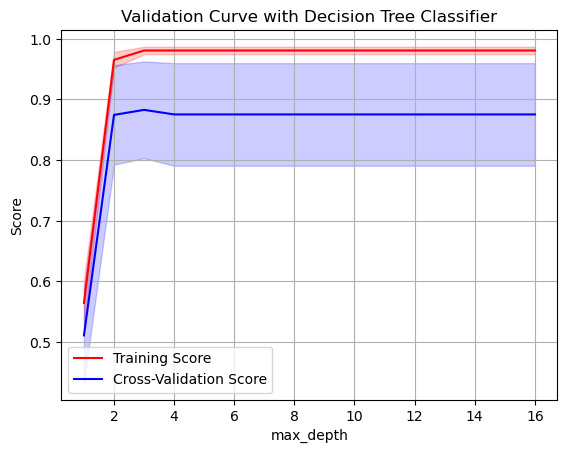

In [16]:
# Define range for DecisionTreeClassifier
param_range = np.arange(1, 17)

# Compute using validation_curve
train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(criterion='entropy', min_samples_leaf=3, min_samples_split=2, random_state=42),
    X_train, y_train, param_name='max_depth', param_range=param_range, cv=5, scoring='f1_weighted'
)

# Calculate both mean and standard deviation
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot validation_curve
plt.figure()
plt.plot(param_range, train_scores_mean, label='Training Score', color='r')
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='r')
plt.plot(param_range, test_scores_mean, label='Cross-Validation Score', color='b')
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color='b')
plt.title('Validation Curve with Decision Tree Classifier')
plt.xlabel('max_depth')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

## 5.0 Test Evaluation (Best Model Comparison)

In test evaluation, four main metrics are used to evaluate the classification models. Accuracy meansure the overall correctness, precision gauges the model's ability to identify relevant instances among those predicted positive, recall assesses the model's capability to capture relevant instances and f1 balances precision and recall in a single metric. This offers insights into the model's effectiveness and suitability for classification tasks.

In [17]:
# Re-train KNeighbors on training dataset
best_knn.fit(Xs_train, y_train)
y_pred_knn = best_knn.predict(Xs_test)

# Evaluate KNeighbors model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

# Re-train DecisionTree on training dataset
best_dtree.fit(Xs_train, y_train)
y_pred_dtree = best_dtree.predict(Xs_test)

# Evaluate DecisionTree model
accuracy_dtree = accuracy_score(y_test, y_pred_dtree)
precision_dtree = precision_score(y_test, y_pred_dtree, average='weighted')
recall_dtree = recall_score(y_test, y_pred_dtree, average='weighted')
f1_dtree = f1_score(y_test, y_pred_dtree, average='weighted')

# Re-train LogisticRegression on training dataset
best_logregression.fit(Xs_train, y_train)
y_pred_logregression = best_logregression.predict(Xs_test)

# Evaluate LogisticRegression model
accuracy_logregression = accuracy_score(y_test, y_pred_logregression)
precision_logregression = precision_score(y_test, y_pred_logregression, average='weighted')
recall_logregression = recall_score(y_test, y_pred_logregression, average='weighted')
f1_logregression = f1_score(y_test, y_pred_logregression, average='weighted')

# Retrieve KNeighbors relevant hyperparameters
best_knn_params = best_knn.get_params()
best_knn_n_neighbors = best_knn_params['n_neighbors']
best_knn_metric = best_knn_params['metric']

# Retrieve DecisionTree relevant hyperparameters
best_dtree_params = best_dtree.get_params()
best_dtree_criterion = best_dtree_params['criterion']
best_dtree_max_depth = best_dtree_params['max_depth']
best_dtree_min_samples_leaf = best_dtree_params['min_samples_leaf']
best_dtree_min_samples_split = best_dtree_params['min_samples_split']

# Retrieve LogisticRegression relevant hyperparameters
best_logregression_params = best_logregression.get_params()
best_logregression_C = best_logregression_params['C']
best_logregression_penalty = best_logregression_params['penalty']
best_logregression_solver = best_logregression_params['solver']

# Create results DataFrame
results_df = pd.DataFrame({
    'Model': ['KNeighbors', 'DecisionTree', 'LogisticRegression'],
    'Hyperparameter': [
        f"n_neighbors={best_knn_n_neighbors}, metric={best_knn_metric}",
        f"criterion={best_dtree_criterion}, max_depth={best_dtree_max_depth}, min_samples_leaf={best_dtree_min_samples_leaf}, min_samples_split={best_dtree_min_samples_split}",
        f"penalty={best_logregression_penalty}, C={best_logregression_C}, solver={best_logregression_solver}"
    ],
    'Accuracy (Validation)': [
        my_knn_grid_search.best_score_,
        dtree_grid_search.best_score_,
        logregression_grid_search.best_score_
    ],
    'Accuracy (Test)': [accuracy_knn, accuracy_dtree, accuracy_logregression],
    'Precision (Test)': [precision_knn, precision_dtree, precision_logregression],
    'Recall (Test)': [recall_knn, recall_dtree, recall_logregression],
    'F1 Score (Test)': [f1_knn, f1_dtree, f1_logregression]
})

# Display results DataFrame
results_df

Model                                     Hyperparameter  \
0          KNeighbors                    n_neighbors=1, metric=euclidean   
1        DecisionTree  criterion=entropy, max_depth=3, min_samples_le...   
2  LogisticRegression                   penalty=l2, C=0.01, solver=lbfgs   

   Accuracy (Validation)  Accuracy (Test)  Precision (Test)  Recall (Test)  \
0                    NaN         1.000000          1.000000       1.000000   
1               0.882705         0.939394          0.950413       0.939394   
2               0.984374         1.000000          1.000000       1.000000   

   F1 Score (Test)  
0         1.000000  
1         0.941097  
2         1.000000

Let's display the best performing model along with its statistics below:

In [18]:
# Calculate the mean of the following metrics
results_df['Mean Score (Test)'] = results_df[['Accuracy (Test)', 'Precision (Test)', 'Recall (Test)', 'F1 Score (Test)']].mean(axis=1)

# Identify the (best) model with the highest mean
best_model_idxmax = results_df['Mean Score (Test)'].idxmax()
best_model = results_df.iloc[best_model_idxmax]

# Print stats of the (best) model
print(f"The best performing model is {best_model['Model']}")
print("The hyperparameters are as follows :\n")
print(f"Accuracy (Validation): {best_model['Accuracy (Validation)']:.2f}")
print(f"Accuracy (Test): {best_model['Accuracy (Test)']:.2f}")
print(f"Precision (Test): {best_model['Precision (Test)']:.2f}")
print(f"Recall (Test): {best_model['Recall (Test)']:.2f}")
print(f"F1 Score (Test): {best_model['F1 Score (Test)']:.2f}")

The best performing model is KNeighbors
The hyperparameters are as follows :

Accuracy (Validation): nan
Accuracy (Test): 1.00
Precision (Test): 1.00
Recall (Test): 1.00
F1 Score (Test): 1.00


### 5.1 K-Nearest Neighbors Results

The K-Nearest Neighbors classifier has been trained and evaluated on the test set. The performance metrics and confusion matrix are displayed below:

K-Nearest Neighbors Model Performance
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

K-Nearest Neighbors Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33



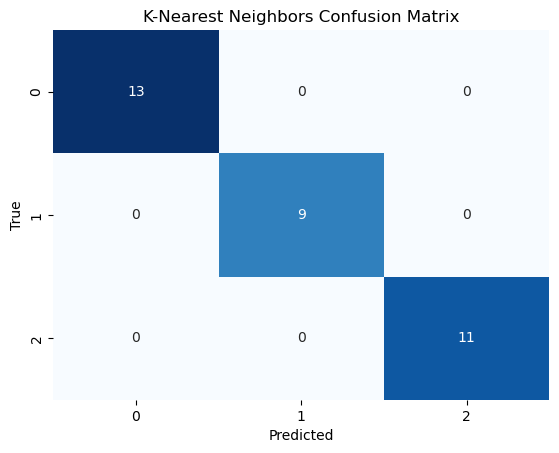

In [19]:
# KNeighbors model performance
print("K-Nearest Neighbors Model Performance")
print(f"Accuracy: {accuracy_knn:.2f}")
print(f"Precision: {precision_knn:.2f}")
print(f"Recall: {recall_knn:.2f}")
print(f"F1 Score: {f1_knn:.2f}")
print("\nK-Nearest Neighbors Classification Report\n", classification_report(y_test, y_pred_knn))

# KNeighbors confusion matrix
knn_confusion_matrix = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(knn_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('K-Nearest Neighbors Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### 5.2 Decision Tree Results

The Decision Tree classifier has been trained and evaluated on the test set. The performance metrics and confusion matrix are displayed below:

Decision Tree Model Performance
Accuracy: 0.94
Precision: 0.95
Recall: 0.94
F1 Score: 0.94

Decision Tree Classification Report
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       0.82      1.00      0.90         9
           2       1.00      0.91      0.95        11

    accuracy                           0.94        33
   macro avg       0.94      0.94      0.94        33
weighted avg       0.95      0.94      0.94        33



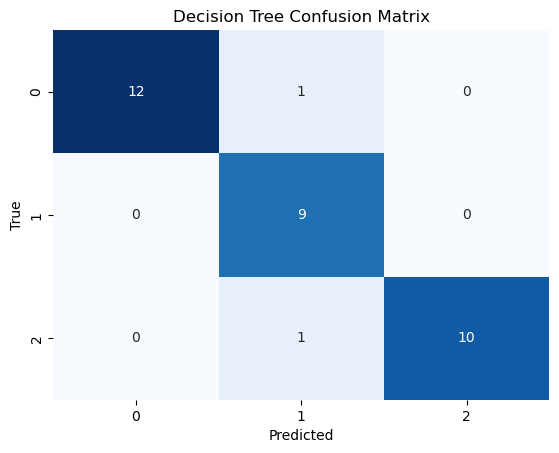

In [20]:
# DecisionTree model performance
print("Decision Tree Model Performance")
print(f"Accuracy: {accuracy_dtree:.2f}")
print(f"Precision: {precision_dtree:.2f}")
print(f"Recall: {recall_dtree:.2f}")
print(f"F1 Score: {f1_dtree:.2f}")
print("\nDecision Tree Classification Report\n", classification_report(y_test, y_pred_dtree))

# DecisionTree confusion matrix
dtree_confusion_matrix = confusion_matrix(y_test, y_pred_dtree)
sns.heatmap(dtree_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### 5.3 Logistic Regression Results

The Logistic Regression classifier has been trained and evaluated on the test set. The performance metrics and confusion matrix are displayed below:

Logistic Regression Model Performance
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

Logistic Regression Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33



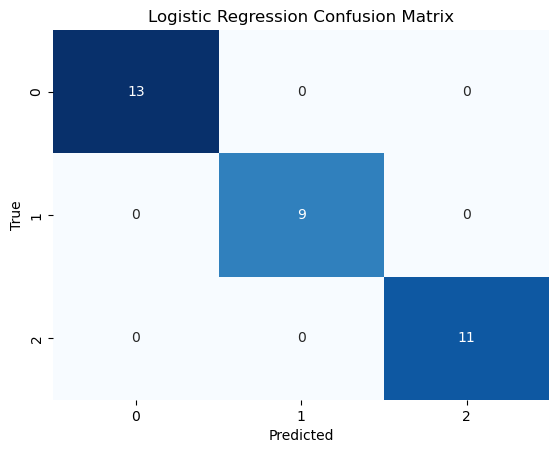

In [21]:
# LogisticRegression model performance
print("Logistic Regression Model Performance")
print(f"Accuracy: {accuracy_logregression:.2f}")
print(f"Precision: {precision_logregression:.2f}")
print(f"Recall: {recall_logregression:.2f}")
print(f"F1 Score: {f1_logregression:.2f}")
print("\nLogistic Regression Classification Report\n", classification_report(y_test, y_pred_logregression))

# LogisticRegression confusion matrix
logregression_confusion_matrix = confusion_matrix(y_test, y_pred_logregression)
sns.heatmap(logregression_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 6.0 Model Interpretation (Feature Importance)

Model interpretation delves into understanding how a model makes predictions. By analysing feature importance, we can understand which features wield the most significance and impact on predictions. This information effectively communicates the model's applicability and decision-making processes.

### 6.1 Decision Tree Feature Importance

Feature importance (Decision Tree) measures the contribution of each feature to the model's predictions. This is typically indicated by a decrease in entropy or Gini impurity where higher feature importance indicates stronger prediction power.

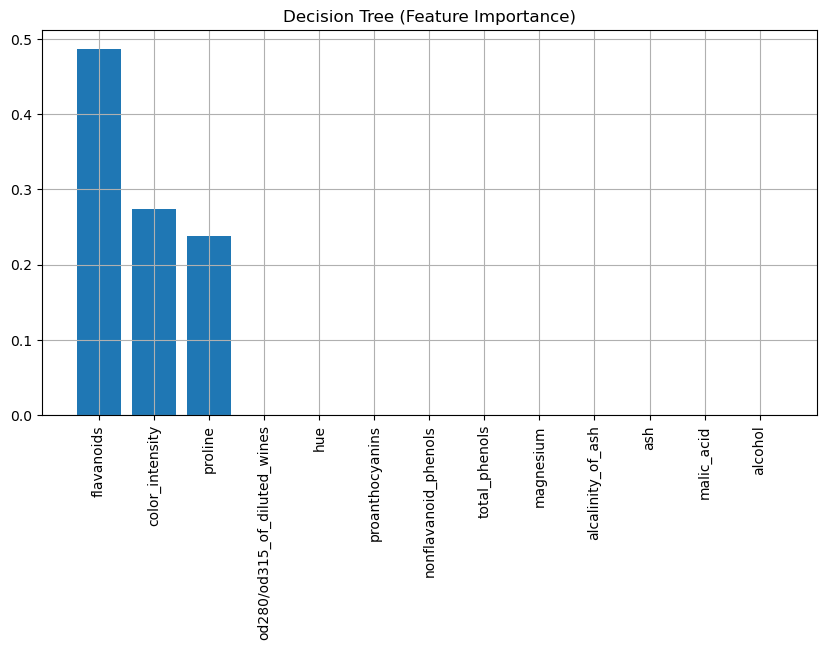

In [22]:
# DecisionTree model feature importance
importances = best_dtree.feature_importances_
feature_names = wine.feature_names
indices = np.argsort(importances)[::-1]

# Plot DecisionTree feature importance
plt.figure(figsize=(10, 5))
plt.title("Decision Tree (Feature Importance)")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.grid()
plt.show()

### 6.1 Logistic Regression Feature Importance

Feature importance (Logistic Regression) is derived from the magnitude of coefficients assigned to features where larger coefficient magnitudes suggets greater importance in predicting the target variable. In other words, every single feature has the power to influence the probability of a particular outcome.

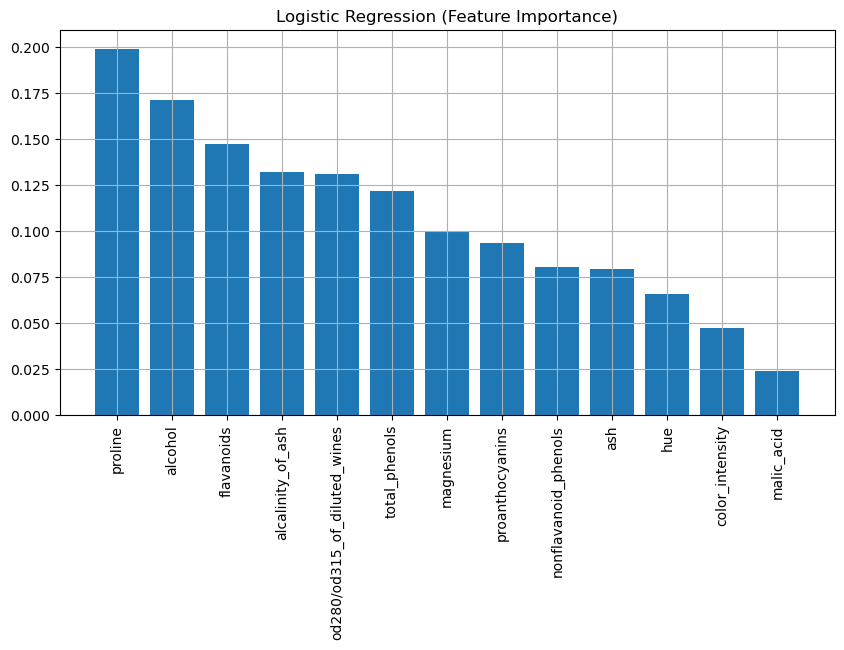

In [23]:
# LogisticRegression model feature importance
coefficients = np.abs(best_logregression.coef_[0])
indices = np.argsort(coefficients)[::-1]

# Plot LogisticRegression feature importance
plt.figure(figsize=(10, 5))
plt.title("Logistic Regression (Feature Importance)")
plt.bar(range(len(coefficients)), coefficients[indices], align='center')
plt.xticks(range(len(coefficients)), [feature_names[i] for i in indices], rotation=90)
plt.grid()
plt.show()

## 7.0 References

[1] Alpaydin, Ethem. Introduction to Machine Learning. 3rd edition, MIT Press, 2014.

[2] Murphy, Kevin P. Machine Learning: A Probabilistic Perspective. MIT Press, 2012.

[3] Muller, Andreas C. Sarah, Guido. Introduction to Machine Learning with Python: A Guide for Data Scientists. O'Reilly Media, 2016.